In [1]:
import torch
import torchvision.transforms as T
import torchvision.models as models

import os
from PIL import Image
import matplotlib.pyplot as plt

import random
import numpy as np
from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
transform = T.Compose([
    T.Resize((256, 128)),
    # 2. Convert the image from a PIL Image object to a PyTorch Tensor.
    T.ToTensor(),
    # 3. Normalize the tensor's pixel values. These specific mean/std values are standard for models pre-trained on ImageNet and help the model perform better.
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def load_market1501_data(data_dir):
    # This list will store tuples of (image_path, person_id, camera_id)
    all_data = []
    # os.listdir gets all file names in the directory. We iterate through them.
    for filename in os.listdir(data_dir):
        # We only want to process files that are '.jpg' images.
        if filename.endswith('.jpg'):
            # The full path to the image file
            path = os.path.join(data_dir, filename)
            # The filename looks like '0001_c1s1_000151_01.jpg'. We split it by the '_' character.
            parts = filename.split('_')
            # The first part '0001' is the person ID (pid). We convert it to an integer.
            pid = int(parts[0])
            # The second part is 'c1s1'. The camera ID is the number after 'c'. We extract it.
            camid = int(parts[1][1])
            
            # The person ID '-1' is used for background images or distractors, which we ignore.
            if pid == -1:
                continue
            
            # We add the parsed information to our list.
            all_data.append((path, pid, camid))
    # Return the list of all processed image data.
    return all_data

In [5]:
# --- Load the actual data ---
# The directory containing the training images of the Market-1501 dataset.
# Make sure you have downloaded and unzipped it in your project folder.
train_dir = 'Market-1501-v15.09.15/bounding_box_train'
# Call our function to load the data.
all_train_data = load_market1501_data(train_dir)

# --- Group images by Person ID for easier triplet sampling later ---
# This dictionary will map each person ID to a list of their images.
pid_to_paths = {}
# We iterate through all the data we just loaded.
for path, pid, camid in all_train_data:
    # If we haven't seen this person ID before, create a new empty list for it.
    if pid not in pid_to_paths:
        pid_to_paths[pid] = []
    # Add the current image's info to the list for this person.
    pid_to_paths[pid].append((path, camid))

# Get a list of all unique person IDs available in the dataset.
unique_pids = list(pid_to_paths.keys())

# Print a summary to confirm everything loaded correctly.
print(f"Loaded {len(all_train_data)} images from {len(unique_pids)} unique people.")

Loaded 12936 images from 751 unique people.


In [6]:
# --- Replace your current Step 4 with this NEW, SIMPLER version ---
import torchreid

print("Attempting to download the pre-trained Re-ID model automatically...")

# We will use the 'pretrained=True' flag which tells the library to
# automatically download the correct weights from the official source.
# This is more robust than using a manual link.
model = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=751, # Number of identities in Market-1501 training set
    loss='triplet',
    pretrained=True # This flag will trigger the automatic download
)

# Move the model to the GPU and set to evaluation mode
model = model.to(device)
model.eval()

# The model from torchreid is already a feature extractor, so we can use it directly.
feature_extractor = model

# Freeze the model's parameters
for param in feature_extractor.parameters():
    param.requires_grad = False

print("Victim model (TorchReID OSNet) is loaded and frozen successfully!")

c:\Users\Public\anaconda3\envs\pytorch_env\Lib\site-packages\torchreid\reid\metrics\rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


Attempting to download the pre-trained Re-ID model automatically...


c:\Users\Public\anaconda3\envs\pytorch_env\Lib\site-packages\torchreid\reid\models\osnet.py:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached

Successfully loaded imagenet pretrained weights from "C:\Users\Uday Raj/.cache\torch\checkpoints\osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Victim model (TorchReID OSNet) is loaded and frozen successfully!


In [7]:
# Cell 5: Initializing the Adversarial Pattern (δ) and Mask (Mx)

# --- Define the size of our pattern ---
# We'll make it the same size as our input images for easy overlaying.
pattern_size = (256, 128) # Height, Width

# --- Initialize the pattern δ ---
# We create a tensor of the desired size with random values between 0 and 1.
# This random noise will be our starting point.
# 'requires_grad=True' is the most important part: it tells PyTorch that we want to
# optimize this tensor. The optimizer will be able to update it.
initial_pattern = torch.rand(1, 3, pattern_size[0], pattern_size[1], device=device, requires_grad=True)

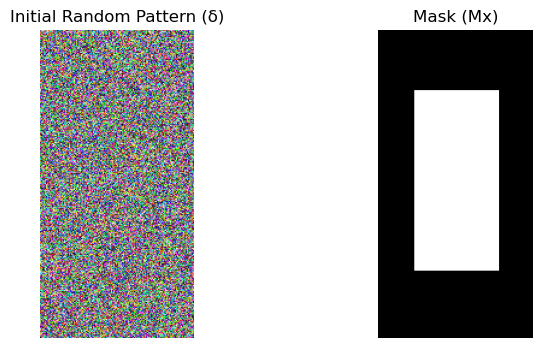

In [8]:
# --- Define the mask Mx ---
# The mask determines where the pattern is applied on the person's body.
# It's a tensor of the same size, filled with zeros.
mask = torch.zeros(1, 1, pattern_size[0], pattern_size[1], device=device)
# We set a rectangular region in the center (the torso area) to 1.
# The pattern will only appear where the mask has a value of 1.
mask[:, :, 50:200, 30:100] = 1

# Display the initial state
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
# '.detach()' is used because matplotlib needs a tensor without gradients. '.cpu()' moves it to the CPU.
# '.squeeze(0)' removes the batch dimension. '.permute(1, 2, 0)' changes from (C, H, W) to (H, W, C) for plotting.
plt.imshow(initial_pattern.detach().cpu().squeeze(0).permute(1, 2, 0))
plt.title("Initial Random Pattern (δ)")
plt.axis('off')

plt.subplot(1, 2, 2)
# '.squeeze(0).squeeze(0)' removes batch and channel dims. 'cmap' makes it grayscale.
plt.imshow(mask.detach().cpu().squeeze(0).squeeze(0), cmap='gray')
plt.title("Mask (Mx)")
plt.axis('off')
plt.show()

In [9]:
# Cell 6: Implementing Transformations (Ti) and Overlay (o)

# We need a function that simulates the pattern being on a person from different angles and positions.
# This corresponds to Ti(δ) and o(xi, ...) in the paper.
def apply_pattern(image_tensor, pattern, mask):
    # This transform simulates 'multi-position sampling' in a simplified way.
    # It will randomly rotate, shift, and scale the input.
    perspective_transform = T.RandomPerspective(distortion_scale=0.2, p=1.0)
    
    # Apply the random perspective transform to both the pattern and the mask.
    # This simulates the pattern being viewed from different angles.
    transformed_pattern = perspective_transform(pattern)
    transformed_mask = perspective_transform(mask)
    
    # The overlay operation o(...):
    # We use the mask to combine the original image with the pattern.
    # Where the mask is 0, we keep the original image pixel.
    # Where the mask is 1, we use the pattern pixel.
    adversarial_image = (1 - transformed_mask) * image_tensor + transformed_mask * transformed_pattern
    
    # Return the final image with the pattern applied.
    return adversarial_image

In [10]:
# Cell 7: Implementing the Loss Functions (Equations 5, 7)

# --- Triplet "Push-Pull" Loss Logic (from Equation 5) ---
# The goal is to make images of the same person from the same camera look similar,
# while making images of the same person from different cameras look different.

# We will use Cosine Similarity to measure how similar two feature vectors are.
# A value of 1 means identical, -1 means opposite, 0 means unrelated.
cosine_similarity = torch.nn.CosineSimilarity(dim=1)

# --- Smoothness Loss (Total Variation, from Equation 7) ---
def total_variation_loss(image):
    # This function penalizes the pattern for having sharp color changes between adjacent pixels.
    # It encourages the optimizer to create a smoother, more natural-looking pattern.
    
    # Horizontal variation: difference between a pixel and the one to its right.
    tv_h = torch.pow(image[:, :, 1:, :] - image[:, :, :-1, :], 2).sum()
    # Vertical variation: difference between a pixel and the one below it.
    tv_w = torch.pow(image[:, :, :, 1:] - image[:, :, :, :-1], 2).sum()
    # The total variation is the sum of these two.
    return (tv_h + tv_w)

In [11]:
# Cell 8: The Full Optimization Loop (Implementing Equation 8)

# --- The Adversarial Pattern ---
# We re-initialize it here so you can re-run this cell to train a new pattern.
# We make it a torch.nn.Parameter so the optimizer can find and update it.
adv_pattern = torch.nn.Parameter(torch.rand(1, 3, 256, 128, device=device))

# --- The Optimizer ---
# We use the Adam optimizer, as specified in the paper.
# We tell it that the ONLY thing it should be updating is our 'adv_pattern'.
optimizer = torch.optim.Adam([adv_pattern], lr=0.01)

# --- Hyperparameters from the Formulas ---
# These are "knobs" we can turn to adjust the training process.
beta = 1.5   # (from Eq. 5) Controls the balance of the push-pull loss.
kappa = 0.5  # (from Eq. 8) Controls the strength of the smoothness loss.

In [13]:
num_iterations = 50000
print("Starting pattern generation...")

# We use tqdm to create a progress bar for our loop.
for i in tqdm(range(num_iterations), desc="Generating Pattern"):
    
    # --- Step 8.1: Sample a Triplet with Hard Negative Mining (xo, x+, x-) ---
    while True: # Loop until we find a valid triplet
        try:
            # Get a random person ID.
            anchor_pid = random.choice(unique_pids)
            # Get all images for this person.
            anchor_paths_cams = pid_to_paths[anchor_pid]
            # Get one random image to be the anchor (xo).
            anchor_path, anchor_cam = random.choice(anchor_paths_cams)
            
            # Find a positive image (x+): another image of the SAME person from the SAME camera.
            positive_path, _ = random.choice([item for item in anchor_paths_cams if item[1] == anchor_cam and item[0] != anchor_path])
            
            # --- Hard Negative Mining Logic Starts Here ---
            # 1. Get a list of all possible negative image paths from different cameras.
            candidate_paths = [item for item in anchor_paths_cams if item[1] != anchor_cam]
            if not candidate_paths: continue # If no negatives exist, restart the loop

            # 2. Sample several (e.g., up to 5) negative candidates.
            num_candidates = min(5, len(candidate_paths))
            chosen_candidate_paths = random.sample(candidate_paths, num_candidates)
            
            # 3. Load and transform the anchor and candidate negatives into tensors.
            anchor_img = transform(Image.open(anchor_path).convert('RGB')).unsqueeze(0).to(device)
            negative_candidates = [transform(Image.open(path).convert('RGB')).unsqueeze(0).to(device) for path, cam in chosen_candidate_paths]
            
            # 4. Find the "hardest" negative (the one most similar to the anchor WITHOUT the pattern).
            with torch.no_grad(): # We don't need to track gradients for this selection process
                anchor_features_orig = feature_extractor(anchor_img).flatten(1)
                hardest_negative_idx = -1
                max_similarity = -2 # Cosine similarity ranges from -1 to 1

                for j, neg_img_candidate in enumerate(negative_candidates): # Used 'j' to avoid conflict with outer 'i'
                    neg_features_orig = feature_extractor(neg_img_candidate).flatten(1)
                    sim = cosine_similarity(anchor_features_orig, neg_features_orig)
                    if sim > max_similarity:
                        max_similarity = sim
                        hardest_negative_idx = j
            
            # 5. Select the hardest negative and the positive for this training step.
            negative_img = negative_candidates[hardest_negative_idx]
            positive_img = transform(Image.open(positive_path).convert('RGB')).unsqueeze(0).to(device)
            # --- End of Hard Negative Mining ---

            break # Exit the while loop since we successfully found a triplet
        except IndexError:
            continue # If any sampling fails, just restart the while loop to try again

    # --- Step 2: Apply Pattern and Degradations (ϕ(...) from Eq. 8) ---
    degradation = T.Compose([
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.GaussianBlur(kernel_size=3), # Add a bit of blur
        T.RandomErasing(p=0.2, scale=(0.02, 0.1)) # Randomly black out a patch of the image
])
    
    adv_anchor = apply_pattern(degradation(anchor_img), adv_pattern, mask)
    adv_positive = apply_pattern(degradation(positive_img), adv_pattern, mask)
    adv_negative = apply_pattern(degradation(negative_img), adv_pattern, mask)

    # --- Step 3: Get Feature Vectors ---
    anchor_features = feature_extractor(adv_anchor).flatten(1)
    positive_features = feature_extractor(adv_positive).flatten(1)
    negative_features = feature_extractor(adv_negative).flatten(1)

    # --- Step 4: Calculate the Total Loss (Equation 8) ---
    sim_neg = cosine_similarity(anchor_features, negative_features)
    sim_pos = cosine_similarity(anchor_features, positive_features)
    push_pull_loss = sim_neg - beta * sim_pos
    
    tv_loss = total_variation_loss(adv_pattern * mask)
    
    total_loss = push_pull_loss + kappa * tv_loss
    
    # --- Step 5: Optimize the Pattern ---
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # --- Step 6: Enforce Printable Colors Constraint (δ ∈ P from Eq. 8) ---
    with torch.no_grad():
        adv_pattern.data.clamp_(0, 1)

print("\nPattern generation complete!")

Starting pattern generation...


Generating Pattern:   0%|          | 0/50000 [00:00<?, ?it/s]


Pattern generation complete!


In [26]:
# Cell 9: Visualize the Final Pattern and an Example Attack

# --- Visualize the pattern ---
# We get the final optimized pattern from the training loop.
final_pattern_numpy = (adv_pattern * mask).detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

# --- Get a sample image to test on ---
# We'll grab the first image from our training data list.
test_path, _, _ = random.choice(all_train_data)
# Load and transform it. '.unsqueeze(0)' adds a batch dimension.
test_img_tensor = transform(Image.open(test_path).convert('RGB')).unsqueeze(0).to(device)

# --- Apply our final pattern to the test image ---
# We use a fixed (non-random) perspective transform for a clear visualization.
fixed_transform = T.RandomPerspective(distortion_scale=0.1, p=1.0)
transformed_pattern = fixed_transform(adv_pattern)
transformed_mask = fixed_transform(mask)
adv_test_img_tensor = (1 - transformed_mask) * test_img_tensor + transformed_mask * transformed_pattern


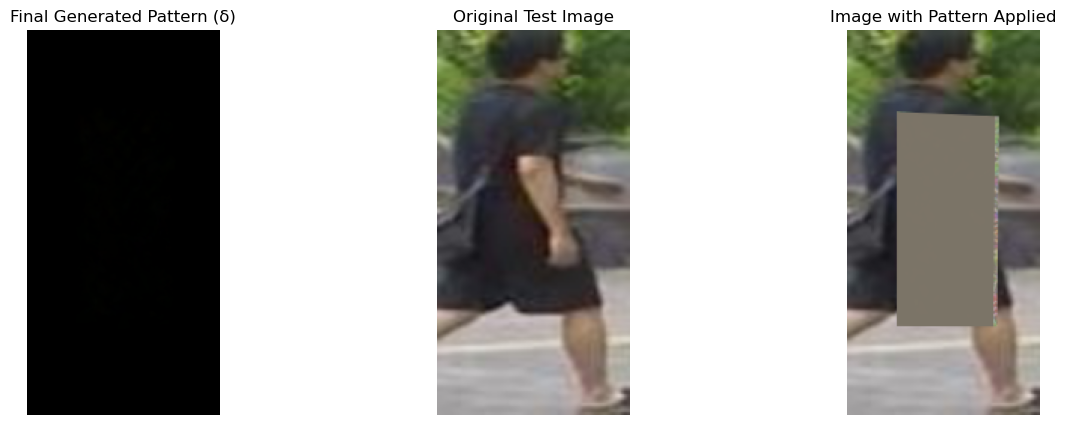

In [27]:
# --- Create a helper function for displaying tensors ---
def imshow_tensor(tensor, title=""):
    # First, we need to un-normalize the image to get the original colors back.
    unnormalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    # Move tensor to CPU, remove batch dim, and change order for matplotlib.
    img_np = unnormalize(tensor.detach()).cpu().squeeze(0).permute(1, 2, 0).numpy()
    # Clip values to be between 0 and 1, as some floating point errors can push them outside.
    img_np = np.clip(img_np, 0, 1)
    # Display the image.
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')

# --- Plot everything ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(final_pattern_numpy)
plt.title("Final Generated Pattern (δ)")
plt.axis('off')

plt.subplot(1, 3, 2)
imshow_tensor(test_img_tensor, title="Original Test Image")

plt.subplot(1, 3, 3)
imshow_tensor(adv_test_img_tensor, title="Image with Pattern Applied")

plt.show()

In [28]:
# --- Simplified Quantitative Check ---
# Let's see if the similarity scores behave as expected on a new triplet.
#
# <<< THIS IS THE CORRECTED SECTION >>>
# Instead of calling a function, we will manually sample a new triplet here.
while True:
    try:
        # Get a random person ID.
        anchor_pid = random.choice(unique_pids)
        # Get all images for this person.
        anchor_paths_cams = pid_to_paths[anchor_pid]
        # Get one random image to be the anchor (xo).
        anchor_path, anchor_cam = random.choice(anchor_paths_cams)
        # Find a positive image (x+): another image of the SAME person from the SAME camera.
        positive_path, _ = random.choice([item for item in anchor_paths_cams if item[1] == anchor_cam and item[0] != anchor_path])
        # Find a negative image (x-): an image of the SAME person from a DIFFERENT camera.
        negative_path, _ = random.choice([item for item in anchor_paths_cams if item[1] != anchor_cam])
        # If all samples are found successfully, break the loop.
        break
    except IndexError:
        # If we fail to find a valid positive or negative (e.g., person only has 1 image in a camera),
        # just try again with a new random person.
        continue

# Load and transform the triplet images into tensors.
anchor_img = transform(Image.open(anchor_path).convert('RGB')).unsqueeze(0).to(device)
positive_img = transform(Image.open(positive_path).convert('RGB')).unsqueeze(0).to(device)
negative_img = transform(Image.open(negative_path).convert('RGB')).unsqueeze(0).to(device)
# <<< END OF CORRECTION >>>


print("\n--- Similarity Scores WITHOUT Attack ---")
feat_a = feature_extractor(anchor_img).flatten(1)
feat_p = feature_extractor(positive_img).flatten(1)
feat_n = feature_extractor(negative_img).flatten(1)
print(f"Anchor vs. Positive (should be high): {cosine_similarity(feat_a, feat_p).item():.4f}")
print(f"Anchor vs. Negative (should be lower): {cosine_similarity(feat_a, feat_n).item():.4f}")

print("\n--- Similarity Scores WITH Attack ---")
adv_a = apply_pattern(anchor_img, adv_pattern, mask)
adv_p = apply_pattern(positive_img, adv_pattern, mask)
adv_n = apply_pattern(negative_img, adv_pattern, mask)
feat_a_adv = feature_extractor(adv_a).flatten(1)
feat_p_adv = feature_extractor(adv_p).flatten(1)
feat_n_adv = feature_extractor(adv_n).flatten(1)
print(f"Anchor vs. Positive (should stay high-ish): {cosine_similarity(feat_a_adv, feat_p_adv).item():.4f}")
print(f"Anchor vs. Negative (should be very low): {cosine_similarity(feat_a_adv, feat_n_adv).item():.4f}")


--- Similarity Scores WITHOUT Attack ---
Anchor vs. Positive (should be high): 0.7168
Anchor vs. Negative (should be lower): 0.7184

--- Similarity Scores WITH Attack ---
Anchor vs. Positive (should stay high-ish): 0.6577
Anchor vs. Negative (should be very low): 0.6150


In [29]:
# Import the 'save_image' utility from torchvision
from torchvision.utils import save_image

# --- The line to save the pattern ---
# We take our final optimized pattern tensor 'adv_pattern'.
# The save_image function handles the conversion from a tensor in the [0, 1] range to a standard image file.
# We'll save it as 'adversarial_pattern.jpg' in your project folder.
save_image(adv_pattern, 'adversarial_pattern.jpg')

print("Adversarial pattern has been saved as 'adversarial_pattern.jpg'")

Adversarial pattern has been saved as 'adversarial_pattern.jpg'
